In [36]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as matplt
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.metrics import mean_squared_error, make_scorer,r2_score
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [4]:
# Get train data
train = pd.read_csv("./Data/train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


In [5]:
# Get test data
test = pd.read_csv("./Data/test.csv")
print("test:" + str(test.shape))

test:(1459, 80)


In [6]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [7]:
# Find data that is quantitative or qualitative

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']


In [8]:
# Check all numerical data and see if they are normlly distributed
# The data can be divided into 3 catogries:
# 1. numerical
# 2. catogorial but appears to be numerical
# 3. catogorial
"""
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
"""

'\nf = pd.melt(train, value_vars=quantitative)\ng = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)\ng = g.map(sns.histplot, "value")\n'

In [9]:
"""
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')    

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(boxplot, "value", "SalePrice")
"""

'\nfor c in qualitative:\n    train[c] = train[c].astype(\'category\')\n    if train[c].isnull().any():\n        train[c] = train[c].cat.add_categories([\'MISSING\'])\n        train[c] = train[c].fillna(\'MISSING\')    \n\ndef boxplot(x, y, **kwargs):\n    sns.boxplot(x=x, y=y)\n    x=plt.xticks(rotation=90)\n\nf = pd.melt(train, id_vars=[\'SalePrice\'], value_vars=qualitative)\ng = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)\ng = g.map(boxplot, "value", "SalePrice")\n'

In [10]:
"""
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)
"""

"\ndef anova(frame):\n    anv = pd.DataFrame()\n    anv['feature'] = qualitative\n    pvals = []\n    for c in qualitative:\n        samples = []\n        for cls in frame[c].unique():\n            s = frame[frame[c] == cls]['SalePrice'].values\n            samples.append(s)\n        pval = stats.f_oneway(*samples)[1]\n        pvals.append(pval)\n    anv['pval'] = pvals\n    return anv.sort_values('pval')\n\na = anova(train)\na['disparity'] = np.log(1./a['pval'].values)\nsns.barplot(data=a, x='feature', y='disparity')\nx=plt.xticks(rotation=90)\n"

0.12122191311528363

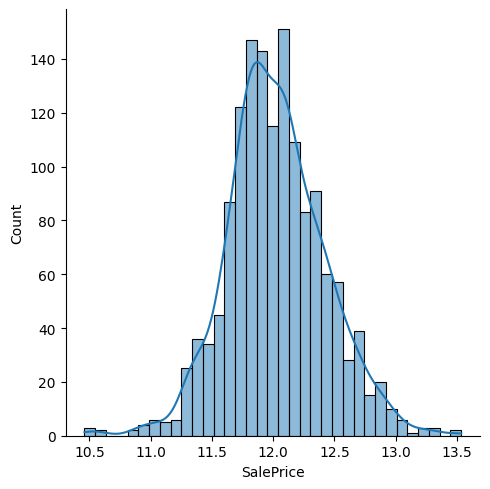

In [11]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.displot(train['SalePrice'],kde=True)
skew(train['SalePrice'])


In [12]:
# normalize quantitative variables
skewedset = all_data[quantitative].apply(lambda x: skew(x.dropna()))
skewedset = skewedset[skewedset > .75]
skewedset = skewedset.index

all_data[skewedset] = np.log1p(all_data[skewedset])


In [13]:
# dummy variables
all_data = pd.get_dummies(all_data)

In [14]:
all_data = all_data.fillna(train.mean())

C:\Users\xiaos\AppData\Local\Temp\ipykernel_7844\3399601051.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_data = all_data.fillna(train.mean())


In [15]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y.shape)

(1460, 288)
(1459, 288)
(1460,)


In [17]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [18]:
def save_result(y_pred_test,label,filename):
    result = pd.concat([label, pd.Series(y_pred_test)],axis=1,keys=['Id','SalePrice'])

Text(0, 0.5, 'rmse')

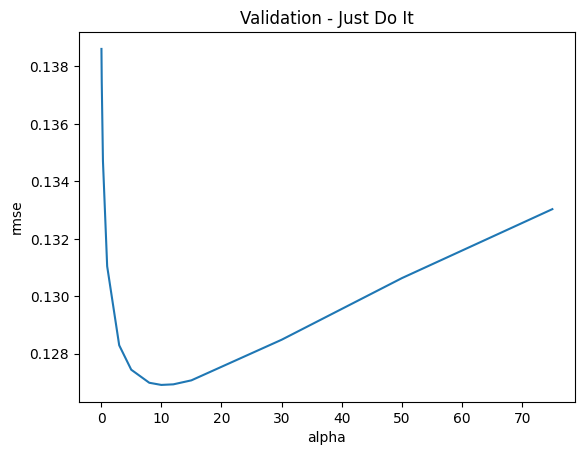

In [19]:
# Ridge regression
model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 8, 10, 12, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [20]:
# Ridge for the testing set
model_ridge = Ridge(alpha=10)
# model_ridge.fit(X_train,y)


# 
# y_pred_test.shape

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X_train):
    X_train_p, X_val_p = X_train.iloc[train_index],X_train.iloc[test_index]
    y_train_p, y_val_p = y.iloc[train_index], y.iloc[test_index]

    model_ridge.fit(X_train_p,y_train_p) 
    y_val_pred = model_ridge.predict(X_val_p)
    print(mean_squared_error(y_val_p, y_val_pred))

    

y_pred_test=model_ridge.predict(X_test)
y_pred_test = np.expm1(y_pred_test)


0.013351651441457993
0.009752339183477243
0.012197685215631877
0.025141465675070054
0.020153050705695938
0.010814777859456559
0.013940932218185764
0.009796746445935886
0.029896489623560972
0.016753867088674292


In [22]:
# Pack the data into csv file
result_ridge = pd.concat([test['Id'],pd.Series(y_pred_test)], axis=1, keys=['Id','SalePrice'])
result_ridge.to_csv('Ridge_v2.csv', index=False)

In [23]:
# Lasso 

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()


0.12269759383995163

In [34]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print(str(sum(coef != 0)))
print(str(sum(coef == 0)))

107
181


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

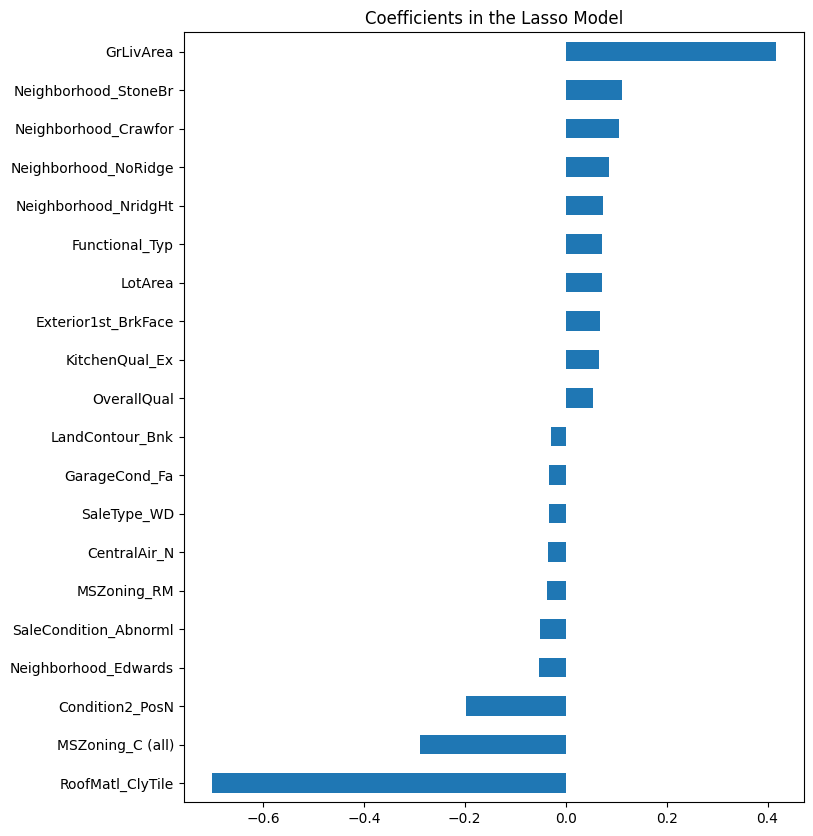

In [37]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [38]:
y_pred_lasso=model_lasso.predict(X_test)
y_pred_lasso = np.expm1(y_pred_lasso)

# Pack the data into csv file
result_lasso = pd.concat([test['Id'],pd.Series(y_pred_lasso)], axis=1, keys=['Id','SalePrice'])
result_lasso.to_csv('Lasso_v1.csv', index=False)

In [39]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'